Get data description from pdf file and map it to path of signal data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install PyPDF2
import PyPDF2

In [ ]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
from scipy import signal
import pickle

#1. Get data

In [ ]:
def extract_event_info(event):
  lines = event.strip().split('\n')
  event_number = int(lines[0])
  picked_arrival = re.search(r'Picked arrival: (.+)', event).group(1)
  tag = re.search(r'Tag : (.+)', event).group(1)
  arrival_type = re.search(r'Arrival type : (.+)', event).group(1)
  # Event parameters
  iris_event_id = re.search(r'IRIS Event ID : (\d+)', event).group(1)
  origin_time = re.search(r'Origin time : (.+)', event).group(1)
  latitude = re.search(r'Latitude : (.+)', event).group(1)
  longitude = re.search(r'Longitude : (.+)', event).group(1)
  depth = re.search(r'Depth : (.+)', event).group(1)
  magnitude = re.search(r'Magnitude : (.+)', event).group(1)
  return [event_number, picked_arrival, tag, arrival_type, iris_event_id, origin_time, latitude, longitude, depth, magnitude]

pdf_path = '/content/drive/MyDrive/MERMAIDAI/Pipatprathanporn+2021-SM1.pdf'

info = []
# Ouvrir le fichier PDF en mode binaire
with open(pdf_path, 'rb') as file:
    # Initialiser le lecteur PDF
    pdf_reader = PyPDF2.PdfReader(file)

    # Parcourir les pages du PDF
    for page_num in range(1, len(pdf_reader.pages)):  # Commencer à la deuxième page
        # Obtenir le contenu de la page
        page = pdf_reader.pages[page_num]
        page_content = page.extract_text()

        # Extraire la valeur de "Picked arrival"
        info_event = extract_event_info(page_content)
        info.append(info_event)

info = np.array(info)
df = pd.DataFrame(info, columns=['Event number', 'Picked arrival', 'Tag', 'Arrival type', 'IRIS Event ID', 'Original time', 'Latitude', 'Longitude', 'Depth', 'Magnitude'])
df.head()

,Event number,Picked arrival,Tag,Arrival type,IRIS Event ID,Original time,Latitude,Longitude,Depth,Magnitude
0,1,2018-11-18 20:32:00.000,DET,body,10972756,2018-11-18 20:25:46.590,-17.8735,-178.9273,540.0000,6.80 Mww
1,2,2018-11-30 17:42:00.000,DET,body,10976411,2018-11-30 17:29:29.330,61.3464,-149.9552,46.7000,7.00 mww
2,3,2018-12-05 04:26:35.000,DET,body,10980271,2018-12-05 04:18:08.400,-21.9568,169.4179,10.0000,7.50 Mww
3,4,2018-12-11 02:38:40.000,DET,body,10983619,2018-12-11 02:26:32.730,-58.5981,-26.4656,164.6600,7.10 mww
4,5,2018-12-23 23:14:45.000,DET,body,10988734,2018-12-23 23:08:43.340,-20.2873,-175.0923,113.0000,6.40 mww


#2. Data Description

In [ ]:
df['Picked arrival'] = pd.to_datetime(df['Picked arrival'], format='mixed', errors='coerce')
df['Original time'] = pd.to_datetime(df['Original time'], format='mixed', errors='coerce')
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
df['Depth'] = pd.to_numeric(df['Depth'], errors='coerce')
df['Magnitude'] = df['Magnitude'].str.replace(pat='mww', repl='', case=False,)
df['Magnitude'] = pd.to_numeric(df['Magnitude'], errors='coerce')
df['file'] = ['vide' for _ in range(len(df))]
df['file_start'] = ['vide' for _ in range(len(df))]
df

,Event number,Picked arrival,Tag,Arrival type,IRIS Event ID,Original time,Latitude,Longitude,Depth,Magnitude,file,file_start
0,1,2018-11-18 20:32:00,DET,body,10972756,2018-11-18 20:25:46.590,-17.8735,-178.9273,540.00,6.8,vide,vide
1,2,2018-11-30 17:42:00,DET,body,10976411,2018-11-30 17:29:29.330,61.3464,-149.9552,46.70,7.0,vide,vide
2,3,2018-12-05 04:26:35,DET,body,10980271,2018-12-05 04:18:08.400,-21.9568,169.4179,10.00,7.5,vide,vide
3,4,2018-12-11 02:38:40,DET,body,10983619,2018-12-11 02:26:32.730,-58.5981,-26.4656,164.66,7.1,vide,vide
4,5,2018-12-23 23:14:45,DET,body,10988734,2018-12-23 23:08:43.340,-20.2873,-175.0923,113.00,6.4,vide,vide
...,...,...,...,...,...,...,...,...,...,...,...,...
208,209,2019-08-02 01:26:00,S1,surface,11090368,2019-08-02 00:55:16.872,-34.1794,-72.1980,14.04,5.4,vide,vide
209,210,2019-08-06 17:40:00,S1,surface,11092784,2019-08-06 17:20:57.028,-6.0700,-107.3111,10.00,NaN,vide,vide
210,211,2019-08-06 22:22:00,*,body,11092895,2019-08-06 22:14:14.863,-17.9594,168.5844,150.00,5.9,vide,vide
211,212,2019-08-07 05:41:40,*,body,11093088,2019-08-07 05:32:40.468,-15.5082,167.7054,123.30,5.8,vide,vide


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Event number    213 non-null    object        
 1   Picked arrival  213 non-null    datetime64[ns]
 2   Tag             213 non-null    object        
 3   Arrival type    213 non-null    object        
 4   IRIS Event ID   213 non-null    object        
 5   Original time   213 non-null    datetime64[ns]
 6   Latitude        213 non-null    float64       
 7   Longitude       213 non-null    float64       
 8   Depth           213 non-null    float64       
 9   Magnitude       182 non-null    float64       
 10  file            213 non-null    object        
 11  file_start      213 non-null    object        
dtypes: datetime64[ns](2), float64(4), object(6)
memory usage: 20.1+ KB


In [ ]:
df.describe()

,Picked arrival,Original time,Latitude,Longitude,Depth,Magnitude
count,213,213,213.000000,213.000000,213.000000,182.000000
mean,2019-03-10 22:12:00.867802880,2019-03-10 21:59:04.962605824,-10.749009,-12.800678,49.531408,6.066484
min,2018-09-15 08:20:00,2018-09-15 08:05:29.100000,-61.293600,-179.977600,5.110000,5.000000
25%,2018-12-11 02:38:40,2018-12-11 02:26:32.729999872,-28.974500,-128.683500,10.000000,5.700000
50%,2019-03-20 19:09:30,2019-03-20 19:03:01.784000,-15.776100,-75.277500,10.000000,6.000000
75%,2019-06-16 05:23:30,2019-06-16 05:17:16.244000,2.241400,141.625200,35.000000,6.300000
max,2019-08-14 22:02:00,2019-08-14 21:35:18.158000,61.346400,178.205900,652.350000,8.000000
std,NaN,NaN,27.869344,138.947605,100.067325,0.538186


#3. Get signal from DonneesB23

In [ ]:
for i in range(len(df)):
    print(i, '/', len(df))
    event_time = df.loc[i,'Picked arrival']
    for dossier_actuel, sous_dossiers, fichiers in os.walk('/content/drive/MyDrive/MERMAIDAI/data/DonneesB23'):
        for fichier in fichiers:
            if fichier[0] == '2' :
                fichier_time = datetime.strptime(fichier[:19], '%Y-%m-%dT%H_%M_%S')
                fichier_time = fichier_time.replace(microsecond=0)
                if event_time >= fichier_time:
                        fs = 40
                        path = os.path.join(dossier_actuel, fichier)
                        y = np.fromfile(path, dtype=np.int32)
                        duree_sigal_s = int(len(y)/fs)
                        if (event_time - fichier_time).total_seconds() < duree_sigal_s:
                            if df.loc[i,'file'] != 'vide':
                                print("Attention, deux fichiers pour l'événement {} !".format(i))
                            df.loc[i,'file'] = path
                            df.loc[i,'file_start'] = fichier_time
                            break

In [ ]:
df.head()

,Event number,Picked arrival,Tag,Arrival type,IRIS Event ID,Original time,Latitude,Longitude,Depth,Magnitude,file,file_start
0,1,2018-11-18 20:32:00,DET,body,10972756,2018-11-18 20:25:46.590,-17.8735,-178.9273,540.00,6.8,vide,vide
1,2,2018-11-30 17:42:00,DET,body,10976411,2018-11-30 17:29:29.330,61.3464,-149.9552,46.70,7.0,vide,vide
2,3,2018-12-05 04:26:35,DET,body,10980271,2018-12-05 04:18:08.400,-21.9568,169.4179,10.00,7.5,vide,vide
3,4,2018-12-11 02:38:40,DET,body,10983619,2018-12-11 02:26:32.730,-58.5981,-26.4656,164.66,7.1,vide,vide
4,5,2018-12-23 23:14:45,DET,body,10988734,2018-12-23 23:08:43.340,-20.2873,-175.0923,113.00,6.4,vide,vide


In [ ]:
# Check if all file is list
fichiers = df['file'].to_numpy()
(fichiers == 'vide').sum()/len(fichiers)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213 entries, 2018-11-18 20:32:00.000 to 2019-08-12 10:45:00.000
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Tag            213 non-null    object 
 1   Arrival type   213 non-null    object 
 2   IRIS Event ID  213 non-null    int64  
 3   Original time  213 non-null    object 
 4   Latitude       213 non-null    float64
 5   Longitude      213 non-null    float64
 6   Depth          213 non-null    float64
 7   Magnitude      182 non-null    float64
 8   file           213 non-null    object 
 9   file_start     213 non-null    object 
 10  diff_start     213 non-null    float64
 11  length_signal  213 non-null    float64
 12  diff_end       213 non-null    float64
dtypes: float64(7), int64(1), object(5)
memory usage: 23.3+ KB


In [ ]:
df['Picked arrival'] = pd.to_datetime(df['Picked arrival'])
df['file_start'] = pd.to_datetime(df['file_start'])

diff_start = (df['Picked arrival'] - df['file_start']).dt.total_seconds()
df['diff_start'] = diff_start

In [ ]:
for i in range(1, len(df)+1):
    print(i, '/', len(df))
    path = df.loc[i,'file']
    # print(path)
    y = np.fromfile(path, dtype=np.int32)
    duree_sigal_s = int(len(y)/40)
    df.loc[i,'length_signal'] = duree_sigal_s

In [ ]:
diff_end = (df['length_signal'] - df['diff_start'])
df['diff_end'] = diff_end

In [ ]:
dir_path = '/content/drive/MyDrive/MERMAIDAI/data/DonneesB23'

In [ ]:
df.to_csv('/content/drive/MyDrive/MERMAIDAI/info_events.csv', index=False)

#4. Checking data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MERMAIDAI/info_events.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/MERMAIDAI/info_events.csv'

In [ ]:
df

,Picked arrival,Tag,Arrival type,IRIS Event ID,Original time,Latitude,Longitude,Depth,Magnitude,file,file_start,diff_start,length_signal,diff_end
0,2018-11-18 20:32:00.000,DET,body,10972756,2018-11-18 20:25:46.590,-17.8735,-178.9273,540.00,6.8,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-11-18 01:22:16,68984.0,69161.0,177.0
1,2018-11-30 17:42:00.000,DET,body,10976411,2018-11-30 17:29:29.330,61.3464,-149.9552,46.70,7.0,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-11-30 07:31:32,36628.0,36806.0,178.0
2,2018-12-05 04:26:35.000,DET,body,10980271,2018-12-05 04:18:08.400,-21.9568,169.4179,10.00,7.5,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-12-02 02:26:15,266420.0,266691.0,271.0
3,2018-12-11 02:38:40.000,DET,body,10983619,2018-12-11 02:26:32.730,-58.5981,-26.4656,164.66,7.1,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-12-07 20:15:43,282177.0,282412.0,235.0
4,2018-12-23 23:14:45.000,DET,body,10988734,2018-12-23 23:08:43.340,-20.2873,-175.0923,113.00,6.4,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2018-12-23 20:19:50,10495.0,10681.0,186.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,2019-08-02 01:26:00.000,S1,surface,11090368,2019-08-02 00:55:16.872,-34.1794,-72.1980,14.04,5.4,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-01 22:59:47,8773.0,73833.0,65060.0
209,2019-08-06 17:40:00.000,S1,surface,11092784,2019-08-06 17:20:57.028,-6.0700,-107.3111,10.00,NaN,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-05 16:24:42,90918.0,204230.0,113312.0
210,2019-08-06 22:22:00.000,*,body,11092895,2019-08-06 22:14:14.863,-17.9594,168.5844,150.00,5.9,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-05 16:24:42,107838.0,204230.0,96392.0
211,2019-08-07 05:41:40.000,*,body,11093088,2019-08-07 05:32:40.468,-15.5082,167.7054,123.30,5.8,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2019-08-05 16:24:42,134218.0,204230.0,70012.0


In [ ]:
df.describe()

,IRIS Event ID,Latitude,Longitude,Depth,Magnitude,diff_start,length_signal,diff_end
count,2.130000e+02,213.000000,213.000000,213.000000,182.000000,213.000000,213.000000,213.000000
mean,1.101670e+07,-10.749009,-12.800678,49.531408,6.066484,136098.534469,257850.319249,121751.784779
std,4.089504e+04,27.869344,138.947605,100.067325,0.538186,125651.014293,173839.196884,116999.391799
min,1.094820e+07,-61.293600,-179.977600,5.110000,5.000000,369.000000,1472.000000,177.000000
25%,1.098362e+07,-28.974500,-128.683500,10.000000,5.700000,44310.000000,114064.000000,31984.000000
50%,1.101674e+07,-15.776100,-75.277500,10.000000,6.000000,90918.000000,231161.000000,86919.000000
75%,1.104960e+07,2.241400,141.625200,35.000000,6.300000,194432.000000,390905.000000,184160.000000
max,1.109788e+07,61.346400,178.205900,652.350000,8.000000,598831.000000,648217.000000,615326.000000


In [ ]:
# diff_end min
min = np.random.randint(0, np.max(df['diff_end']))
for i in range(len(df)):
  if df['diff_end'][i] < min:
    min = df['diff_end'][i]
    i_min = i
print(i_min)
print(min)

0
177.0


In [ ]:
# diff_end max
max = np.random.randint(0, np.max(df['diff_end']))
for i in range(len(df)):
  if df['diff_end'][i] > max:
    max = df['diff_end'][i]
    i_max = i
print(i_max)
print(max)

147
615326.0


In [ ]:
total_length = 0
for i in range(len(df)):
  total_length += df['length_signal'][i]
print('total length: ', total_length)
print('total time: {} hr'.format((total_length/40)/3600))

total length:  54922118.0
total time: 381.40359722222223 hr


In [ ]:
y0 = np.fromfile(df['file'][0], dtype=np.int32)
y147 = np.fromfile(df['file'][147], dtype=np.int32)
y0_filtered = np.array(list(get_mov_rms(bp(signal.decimate(y0, 100)))))
y147_filtered = np.array(list(get_mov_rms(bp(signal.decimate(y147, 100)))))

In [1]:
plt.figure(figsize=(20, 10))

plt.subplot(4, 1, 1)
plt.plot(y0)
plt.axvline(df['diff_start'][0]*40, color='r')
plt.xticks(np.arange(0, df['length_signal'][0]*40, step=df['length_signal'][0]*40/10))
plt.xlabel('sample')
plt.ylabel('amplitude')

plt.subplot(4, 1, 2)
plt.plot(y0_filtered)
plt.axvline(df['diff_start'][0]*40/100, color='r')
plt.xticks(np.arange(0, df['length_signal'][0]*40/100, step=df['length_signal'][0]*40/100/10))
plt.xlabel('sample')
plt.ylabel('amplitude')

plt.subplot(4, 1, 3)
plt.plot(y147)
plt.axvline(df['diff_start'][147]*40, color='r')
plt.xticks(np.arange(0, df['length_signal'][147]*40, step=df['length_signal'][147]*40/10))
plt.xlabel('sample')
plt.ylabel('amplitude')

plt.subplot(4, 1, 4)
plt.plot(y147_filtered)
plt.axvline(df['diff_start'][147]*40/100, color='r')
plt.xticks(np.arange(0, df['length_signal'][147]*40/100, step=df['length_signal'][147]*40/100/10))
plt.xlabel('sample')
plt.ylabel('amplitude')

NameError: name 'plt' is not defined

#Files are not labeled

In [ ]:
files_labeled = []
for i in range(len(df)):
  files_labeled.append(df['file'][i])
#213 files

In [ ]:
files_not_labeled = []

for dossier_actuel, sous_dossiers, fichiers in os.walk('/content/drive/MyDrive/MERMAIDAI/data/DonneesB23'):
  for fichier in fichiers:
    path = os.path.join(dossier_actuel, fichier)
    if path not in files_labeled:
      files_not_labeled.append(path)
len(files_not_labeled)
#1064 files

1064

# Check signal in files not labeled

In [ ]:
df_notlabeled = pd.DataFrame(files_not_labeled, columns=['file'])

for i in range(len(df_notlabeled)):
    print(i, '/', len(df_notlabeled))
    path = df_notlabeled.loc[i,'file']
    # print(path)
    y = np.fromfile(path, dtype=np.int32)
    duree_sigal_s = int(len(y)/40)
    df_notlabeled.loc[i,'length_signal_second'] = duree_sigal_s
    df_notlabeled.loc[i,'length_signal'] = duree_sigal_s*40

df_notlabeled

0 / 1064
1 / 1064
2 / 1064
3 / 1064
4 / 1064
5 / 1064
6 / 1064
7 / 1064
8 / 1064
9 / 1064
10 / 1064
11 / 1064
12 / 1064
13 / 1064
14 / 1064
15 / 1064
16 / 1064
17 / 1064
18 / 1064
19 / 1064
20 / 1064
21 / 1064
22 / 1064
23 / 1064
24 / 1064
25 / 1064
26 / 1064
27 / 1064
28 / 1064
29 / 1064
30 / 1064
31 / 1064
32 / 1064
33 / 1064
34 / 1064
35 / 1064
36 / 1064
37 / 1064
38 / 1064
39 / 1064
40 / 1064
41 / 1064
42 / 1064
43 / 1064
44 / 1064
45 / 1064
46 / 1064
47 / 1064
48 / 1064
49 / 1064
50 / 1064
51 / 1064
52 / 1064
53 / 1064
54 / 1064
55 / 1064
56 / 1064
57 / 1064
58 / 1064
59 / 1064
60 / 1064
61 / 1064
62 / 1064
63 / 1064
64 / 1064
65 / 1064
66 / 1064
67 / 1064
68 / 1064
69 / 1064
70 / 1064
71 / 1064
72 / 1064
73 / 1064
74 / 1064
75 / 1064
76 / 1064
77 / 1064
78 / 1064
79 / 1064
80 / 1064
81 / 1064
82 / 1064
83 / 1064
84 / 1064
85 / 1064
86 / 1064
87 / 1064
88 / 1064
89 / 1064
90 / 1064
91 / 1064
92 / 1064
93 / 1064
94 / 1064
95 / 1064
96 / 1064
97 / 1064
98 / 1064
99 / 1064
100 / 1064

,file,length_signal_second,length_signal
0,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,64.0,2560.0
1,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,880.0,35200.0
2,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,268.0,10720.0
3,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,3260.0,130400.0
4,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,268.0,10720.0
...,...,...,...
1059,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,265.0,10600.0
1060,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2672.0,106880.0
1061,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,265.0,10600.0
1062,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,556.0,22240.0


In [ ]:
df_notlabeled.head()

,file,length_signal_second,length_signal
0,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,64.0,2560.0
1,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,880.0,35200.0
2,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,268.0,10720.0
3,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,3260.0,130400.0
4,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,268.0,10720.0


In [ ]:
df_notlabeled.describe()

,length_signal_second,length_signal
count,1064.000000,1.064000e+03
mean,5188.333647,2.075333e+05
std,27826.808393,1.113072e+06
min,0.000000,0.000000e+00
25%,1.000000,4.000000e+01
50%,1.000000,4.000000e+01
75%,268.000000,1.072000e+04
max,468073.000000,1.872292e+07


from matplotlib import pyplot as plt
_df_4['length_signal_second'].plot(kind='hist', bins=20, title='length_signal_second')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['length_signal'].plot(kind='hist', bins=20, title='length_signal')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='length_signal_second', y='length_signal', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['length_signal_second'].plot(kind='line', figsize=(8, 4), title='length_signal_second')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['length_signal'].plot(kind='line', figsize=(8, 4), title='length_signal')
plt.gca().spines[['top', 'right']].set_visible(False)

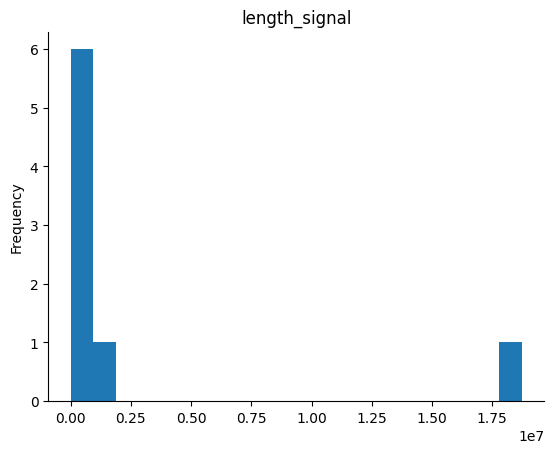

In [ ]:
from matplotlib import pyplot as plt
_df_5['length_signal'].plot(kind='hist', bins=20, title='length_signal')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df_notlabeled_morethan_5s = df_notlabeled[df_notlabeled['length_signal_second'] > 5]
df_notlabeled_morethan_5s.describe()

,length_signal_second,length_signal
count,397.000000,3.970000e+02
mean,13903.612091,5.561445e+05
std,44239.120206,1.769565e+06
min,38.000000,1.520000e+03
25%,268.000000,1.072000e+04
50%,278.000000,1.112000e+04
75%,2672.000000,1.068800e+05
max,468073.000000,1.872292e+07


In [ ]:
df = df_notlabeled_morethan_5s.reset_index(drop=True)

In [ ]:
df

,file,length_signal_second,length_signal
0,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,64.0,2560.0
1,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,880.0,35200.0
2,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,268.0,10720.0
3,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,3260.0,130400.0
4,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,268.0,10720.0
...,...,...,...
392,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,265.0,10600.0
393,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,2672.0,106880.0
394,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,265.0,10600.0
395,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,556.0,22240.0


In [ ]:
df.to_csv('/content/drive/MyDrive/MERMAIDAI/df_notlabeled_morethan_5s.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MERMAIDAI/df_notlabeled_morethan_5s.csv')

In [ ]:
total_length = 0
for i in range(len(df)):
  total_length += df['length_signal'][i]
print('total length: ', total_length)
print('total time: {} hr'.format((total_length/40)/3600))

total length:  220789360.0
total time: 1533.2594444444444 hr


In [ ]:
# min
min = np.random.randint(0, np.max(df['length_signal']))
for i in range(len(df)):
  if df['length_signal'][i] < min:
    min = df['length_signal'][i]
    i_min = i
print(i_min)
print(min)

370
1520.0


In [ ]:
# max
max = np.random.randint(0, np.max(df['length_signal']))
for i in range(len(df)):
  if df['length_signal'][i] > max:
    max = df['length_signal'][i]
    i_max = i
print(i_max)
print(max)

166
18722920.0


Text(0, 0.5, 'amplitude')

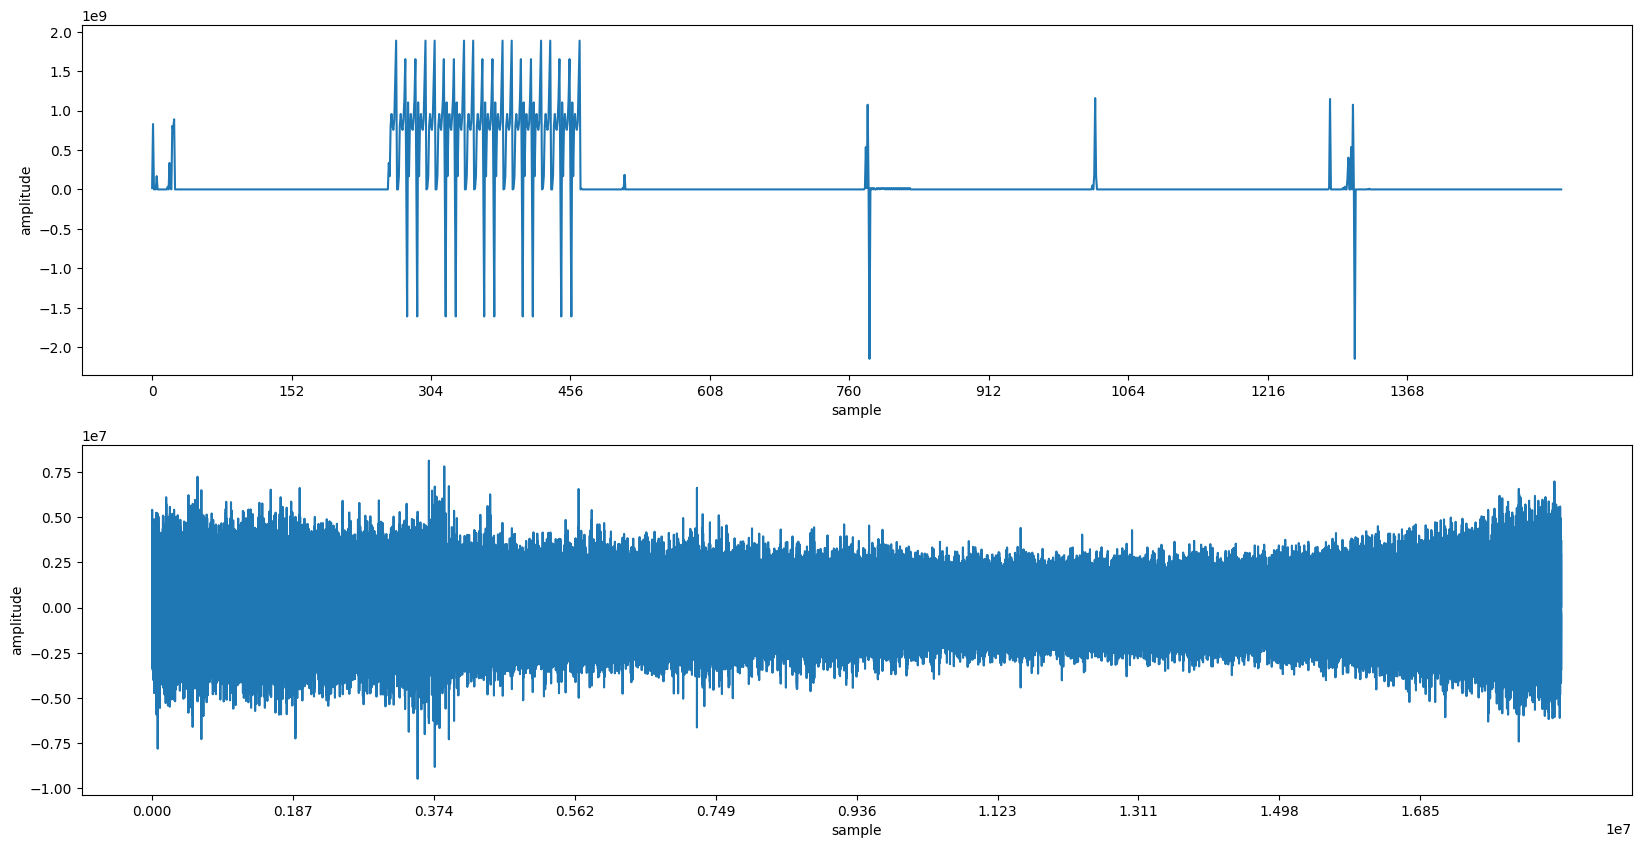

In [ ]:
y370 = np.fromfile(df['file'][370], dtype=np.int32)
y166 = np.fromfile(df['file'][166], dtype=np.int32)


plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.plot(y370)
plt.xticks(np.arange(0, df['length_signal'][370], step=df['length_signal'][370]/10))
plt.xlabel('sample')
plt.ylabel('amplitude')

plt.subplot(2, 1, 2)
plt.plot(y166)
plt.xticks(np.arange(0, df['length_signal'][166], step=df['length_signal'][166]/10))
plt.xlabel('sample')
plt.ylabel('amplitude')

In [ ]:
y = []
for i in range(len(df)):
  y.append(np.fromfile(df['file'][i], dtype=np.int32))
  print(i, '/', len(df))

# Save

In [ ]:
np.savez_compressed('/content/drive/MyDrive/MERMAIDAI/data/raw_signal_0.npz', y[0])

In [ ]:
y0 = np.load('/content/drive/MyDrive/MERMAIDAI/data/raw_signal_0.npz')

In [ ]:
y0['arr_0'].shape

(2766464,)

In [ ]:
for i in range(1, len(y)):
  np.savez_compressed('/content/drive/MyDrive/MERMAIDAI/data/raw_signals_notlabeled/raw_signal_notlabeled_{}.npz'.format(i), y[i])
  print(i, '/', len(y))

#Check

(1472256,)
(1472256,)


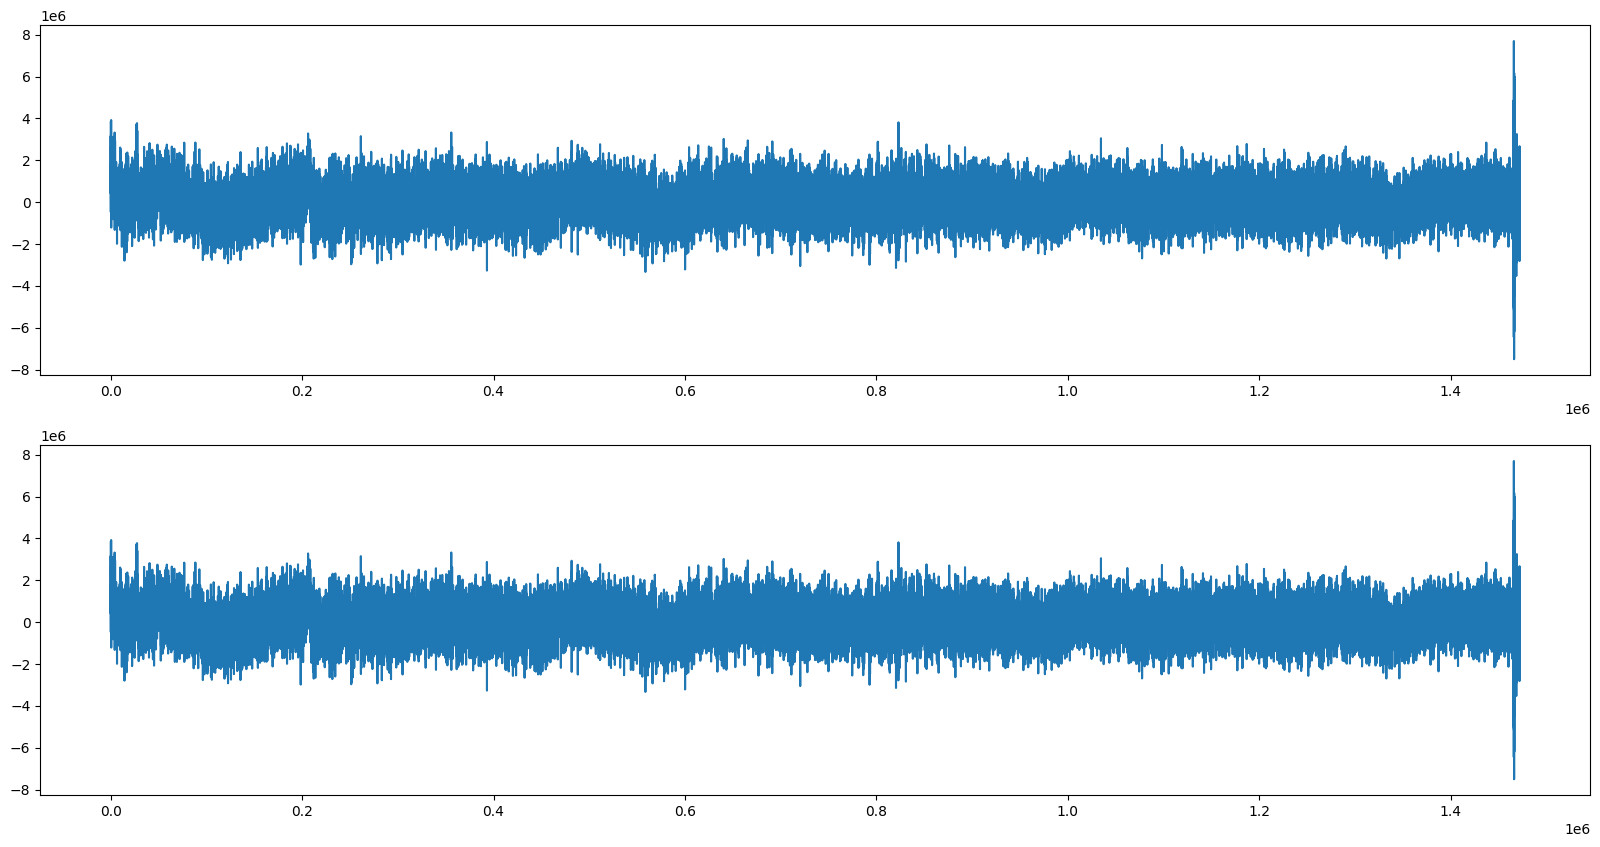

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)
print(y[1].shape)
plt.plot(y[1])

y1 = np.load('/content/drive/MyDrive/MERMAIDAI/data/raw_signals/raw_signal_1.npz')
print(y1['arr_0'].shape)
plt.subplot(2, 1, 2)
plt.plot(y1['arr_0'])

(6904192,)
(6904192,)


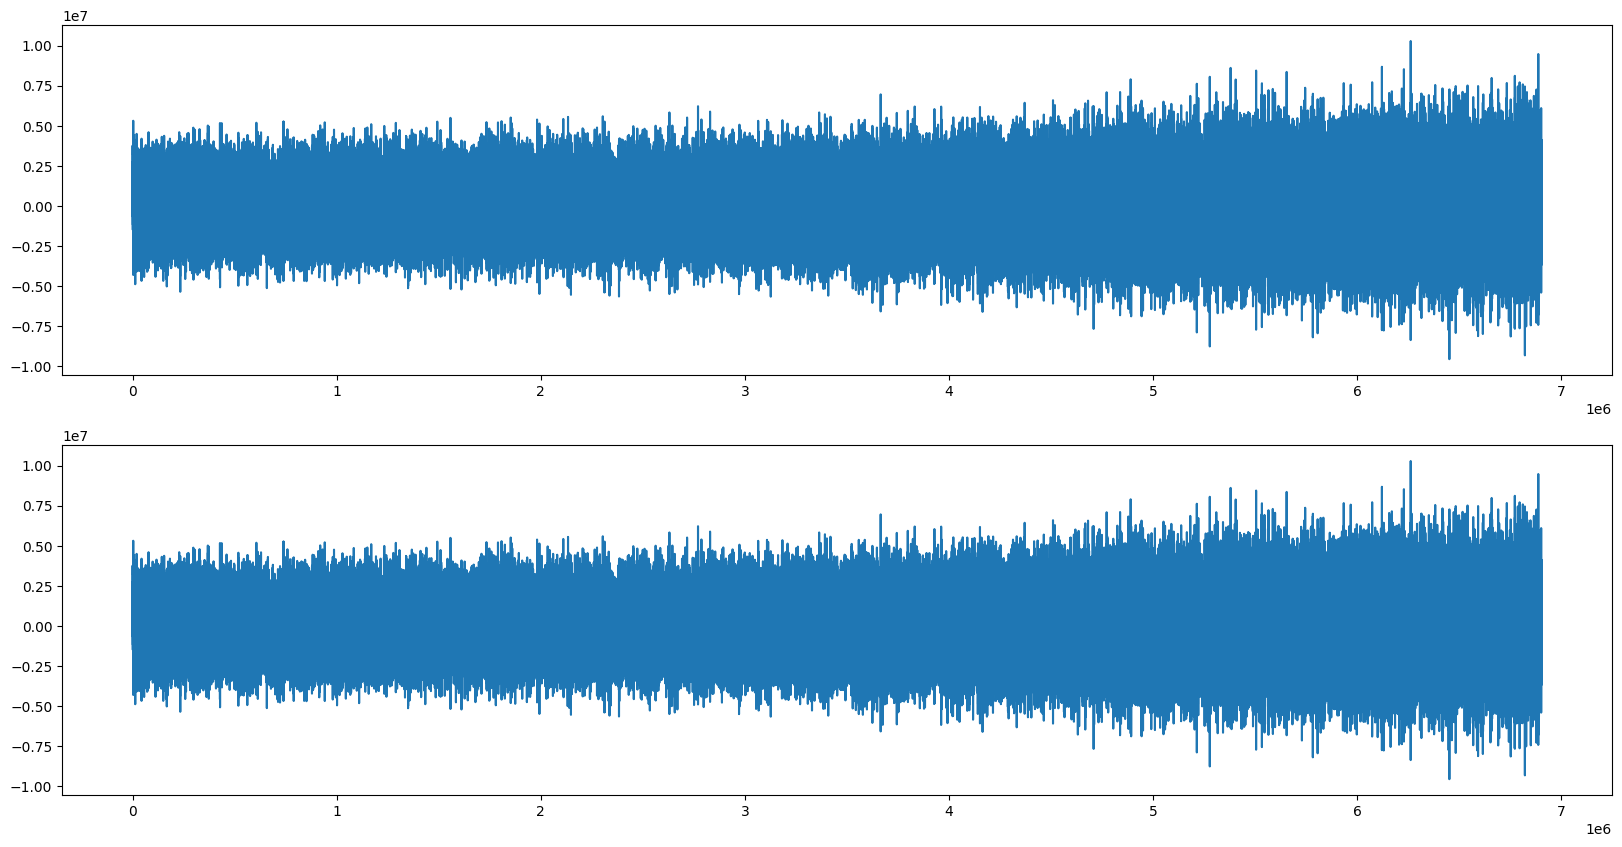

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)
print(y[212].shape)
plt.plot(y[212])

y212 = np.load('/content/drive/MyDrive/MERMAIDAI/data/raw_signals/raw_signal_212.npz')
print(y212['arr_0'].shape)
plt.subplot(2, 1, 2)
plt.plot(y212['arr_0'])

# Signal review

In [ ]:
def bp(y, fs=40/100, lowcut=.05, highcut=.1, order=3) :
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.lfilter(b, a, y)

def get_mov_rms(y, fs=40/100, window=150):
    return np.sqrt(signal.convolve(y**2, np.ones(int(fs*window))/int(fs*window), mode='same'))

def get_mov_mean(y, fs=40/100, window=150):
    return signal.convolve(y, np.ones(int(fs*window))/int(fs*window), mode='same')

## 1

(1472256,)


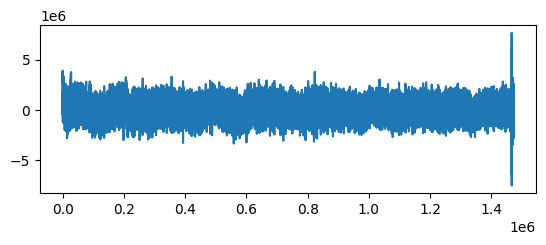

In [ ]:
y1 = np.load('/content/drive/MyDrive/MERMAIDAI/data/raw_signals/raw_signal_1.npz')
print(y1['arr_0'].shape)
plt.subplot(2, 1, 2)
plt.plot(y1['arr_0'])

In [ ]:
diff_1 = (df['Picked arrival'][1] - df['file_start'][1]).total_seconds()
diff_1

68984.0

In [ ]:
y1_decimated = signal.decimate(y1['arr_0'], 100)

In [ ]:
y1_bp = bp(y1_decimated)

In [ ]:
y1_bp.shape

(14723,)

In [ ]:
y1_rms = get_mov_rms(y1_bp)

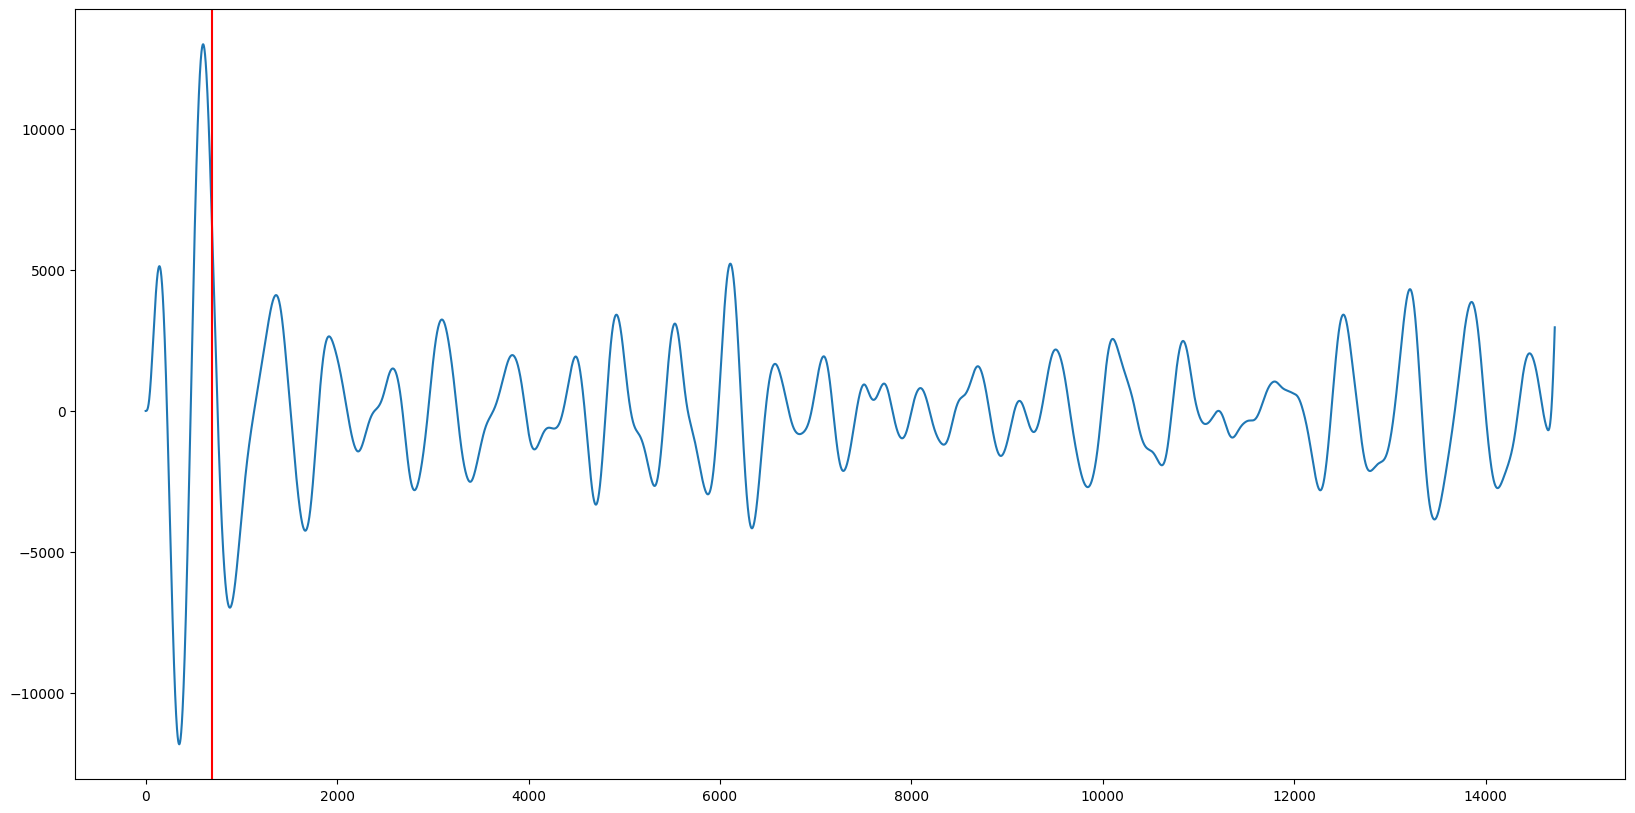

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(bp(y1_rms, fs=40, lowcut=.05, highcut=.1))
# plt.xlim([0, 100000])
plt.axvline(x=diff_1/100, color='r')

##212

(6904192,)


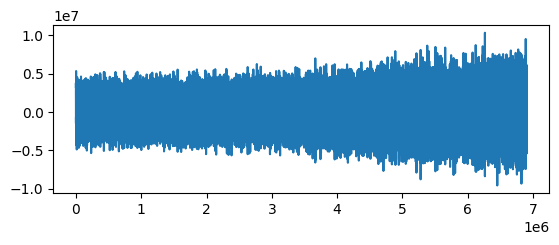

In [ ]:
y212 = np.load('/content/drive/MyDrive/MERMAIDAI/data/raw_signals/raw_signal_212.npz')
print(y212['arr_0'].shape)
plt.subplot(2, 1, 2)
plt.plot(y212['arr_0'])

In [ ]:
diff_212 = (df['Picked arrival'][212] - df['file_start'][212]).total_seconds()
diff_212

134218.0

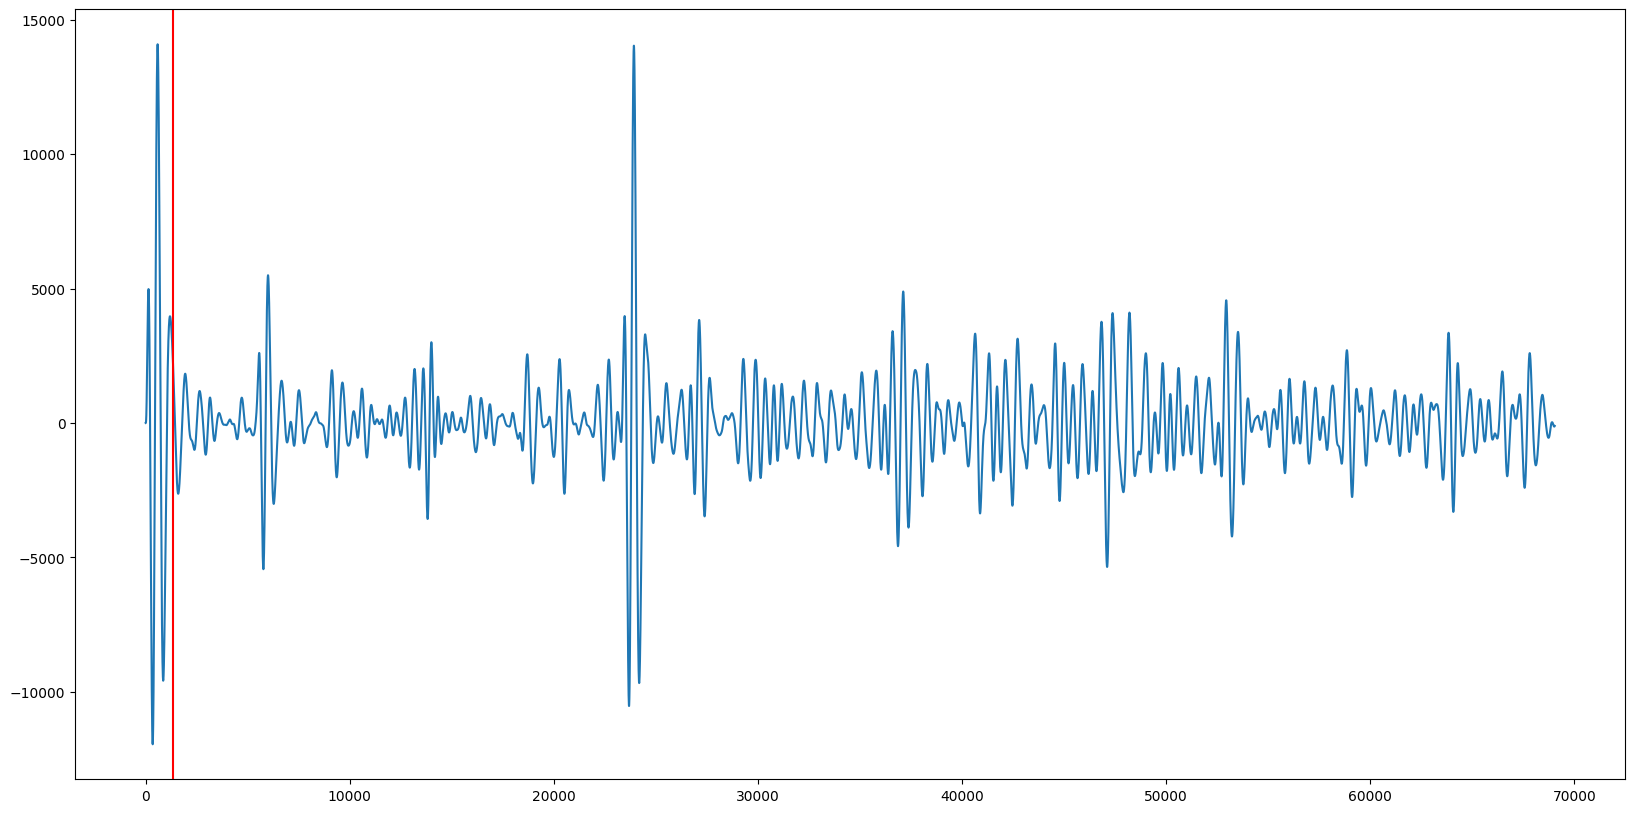

In [ ]:
y212_decimated = signal.decimate(y212['arr_0'], 100)
y212_bp = bp(y212_decimated)
y212_rms = get_mov_rms(y212_bp)

plt.figure(figsize=(20, 10))
plt.plot(bp(y212_rms, fs=40, lowcut=.05, highcut=.1))
# plt.xlim([0, 5000])
plt.axvline(x=diff_212/100, color='r')

# All files

In [ ]:
num_files = []
for dossier_actuel, sous_dossiers, fichiers in os.walk('/content/drive/MyDrive/MERMAIDAI/data/DonneesB23'):
  for fichier in fichiers:
    path = os.path.join(dossier_actuel, fichier)
    num_files.append(path)
len(num_files)

1167

In [ ]:
all_files = []

for dossier_actuel, sous_dossiers, fichiers in os.walk('/content/drive/MyDrive/MERMAIDAI/data/DonneesB23'):
  for fichier in fichiers:
    path = os.path.join(dossier_actuel, fichier)
    y = np.fromfile(path, dtype=np.float32)
    if len(y)/40 > 60*60:
      all_files.append(path)
    del y
len(all_files)

190

In [ ]:
#get X from files_not_labeled

df_notlabeled_morethan_3600s = df[df['length_signal_second'] > 3600]

In [ ]:
df_notlabeled_morethan_3600s = df_notlabeled_morethan_3600s.reset_index(drop=True)

In [ ]:
df_notlabeled_morethan_3600s

,file,length_signal_second,length_signal
0,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,40492.0,1619680.0
1,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,204144.0,8165760.0
2,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,10467.0,418680.0
3,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,7785.0,311400.0
4,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,8976.0,359040.0
...,...,...,...
83,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,4768.0,190720.0
84,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,22176.0,887040.0
85,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,171718.0,6868720.0
86,/content/drive/MyDrive/MERMAIDAI/data/DonneesB...,17385.0,695400.0


In [ ]:
df_notlabeled_morethan_3600s['file'][0]

'/content/drive/MyDrive/MERMAIDAI/data/DonneesB23/2019-01/2019-01-27/2019-01-27T16_28_20.575000'

In [ ]:
signals = []
for i in range(len(df_notlabeled_morethan_3600s)):
  print(i, '/', len(df_notlabeled_morethan_3600s))
  file = df_notlabeled_morethan_3600s['file'][i]
  y = np.fromfile(file, dtype=np.int32, count=144000)
  signals.append(y)
  del y

In [ ]:
X_test = np.array(list(map(get_mov_rms, map(bp,  signal.decimate(signals, 100)))))
print(X_test.shape)

(88, 1440)


In [ ]:
with open('/content/drive/MyDrive/MERMAIDAI/models/rfc_3000.pkl', 'rb') as file:
    rfc = pickle.load(file)

In [ ]:
y_pred = rfc.predict(X_test)

In [ ]:
y_pred[81]

1.0

In [ ]:
for i in range(len(y_pred)):
  if y_pred[i] == 1:
    print(i)

81


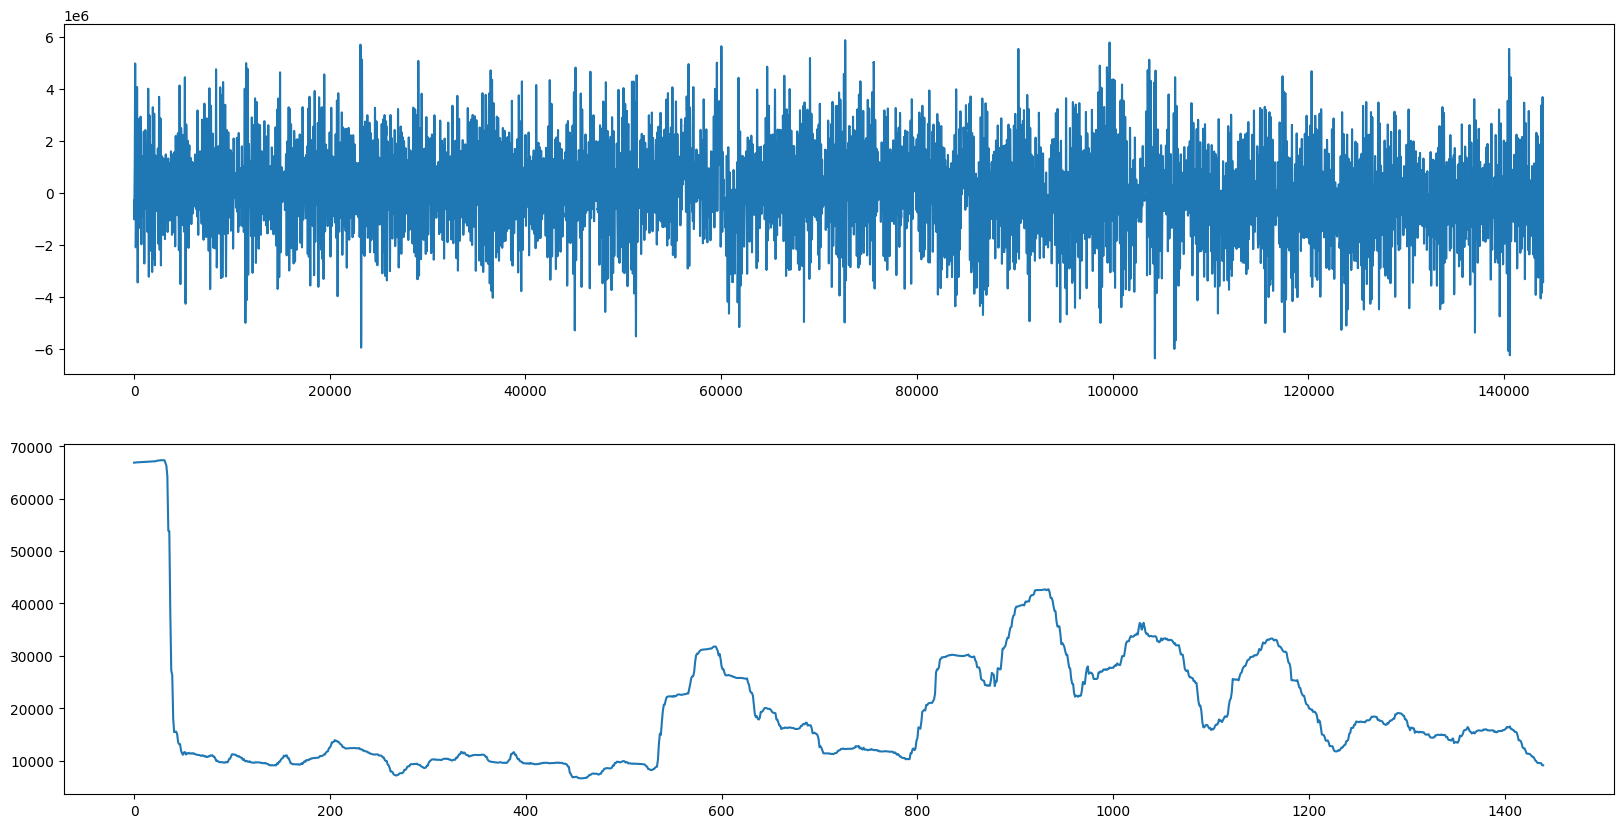

In [ ]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)
plt.plot(signals[81])

plt.subplot(2, 1, 2)
plt.plot(X_test[81])

In [ ]:
np.save('/content/drive/MyDrive/MERMAIDAI/data/all_files_1h.npy', all_files)

In [ ]:
all_files = np.load('/content/drive/MyDrive/MERMAIDAI/data/all_files_1h.npy')

In [ ]:
noisy_files = []
known_files = list(df['file'].unique())
for file in all_files:
  if file not in known_files:
    noisy_files.append(file)
len(noisy_files)  #88

88

In [ ]:
def get_negatives(noisy_files, duree, nb_0, fs=40):
    signals = [ np.fromfile(file, dtype=np.int32) for file in noisy_files]

    X_0 = []
    i = 0
    while len(X_0) < nb_0 :
        T = int(len(signals[i])/fs)
        t = np.random.randint(T - duree)
        y = signals[i][t*fs : t*fs + duree*fs]
        X_0.append(y)

        i = (i + 1) % len(noisy_files)
    return X_0

In [ ]:
def get_positives(files, events_time, demi_duree, n, fs=40, rd=True):

  signal_tronque = []
  signals = [np.fromfile(file, dtype=np.int32) for file in files]

  i = 0
  while len(signal_tronque) < n:
    shift = np.random.normal(loc=0, scale=demi_duree/100, size=1)[0]
    if not rd:
      shift = 0
    a = int(events_time[i] + shift - demi_duree)
    b = int(events_time[i] + shift + demi_duree)

    if a > 0 and b < len(signals[i])/fs:
      y = signals[i][a*fs : b*fs]
      signal_tronque.append(y)

    i = (i+1) % len(files)

  return signal_tronque

In [ ]:
demi_duree = 30*60

n = 1000

#on enlève les séismes * et S1
mask = (df['Tag']!='S1') & (df['Tag']!='*')

#20% pour le jeu de test, ne pas séparer après get_positive car le jeu de test sera biaisé
mask_t = np.random.randint(0, 10, len(mask)) < 8
files = df[ mask & mask_t]['file'].values
events_time = df[ mask & mask_t]['diff'].to_numpy(np.int32)


signal_tronque =  get_positives(files, events_time, demi_duree, n)

print(n, 'positives')

nb_0 = int(n*2)

X_0 = get_negatives(noisy_files, 2*demi_duree, nb_0)

print(nb_0, 'negatives')

y_0 = np.zeros(len(X_0))
y_1 = np.ones(len(signal_tronque))

X = np.concatenate((X_0, signal_tronque))
y = np.concatenate((y_0, y_1))


del X_0, y_0, y_1, signal_tronque

1000 positives
2000 negatives


In [ ]:
print(X.shape, y.shape)

(3000, 144000) (3000,)


In [ ]:
X = np.array(list(map(get_mov_rms, map(bp,  signal.decimate(X, 100)))))
print(X.shape)

(3000, 1440)


In [ ]:
np.save('/content/drive/MyDrive/MERMAIDAI/data/3000X.csv', X)
np.save('/content/drive/MyDrive/MERMAIDAI/data/3000y.csv', y)

In [ ]:
X = np.load('/content/drive/MyDrive/MERMAIDAI/data/3000X.csv.npy')
y = np.load('/content/drive/MyDrive/MERMAIDAI/data/3000y.csv.npy')

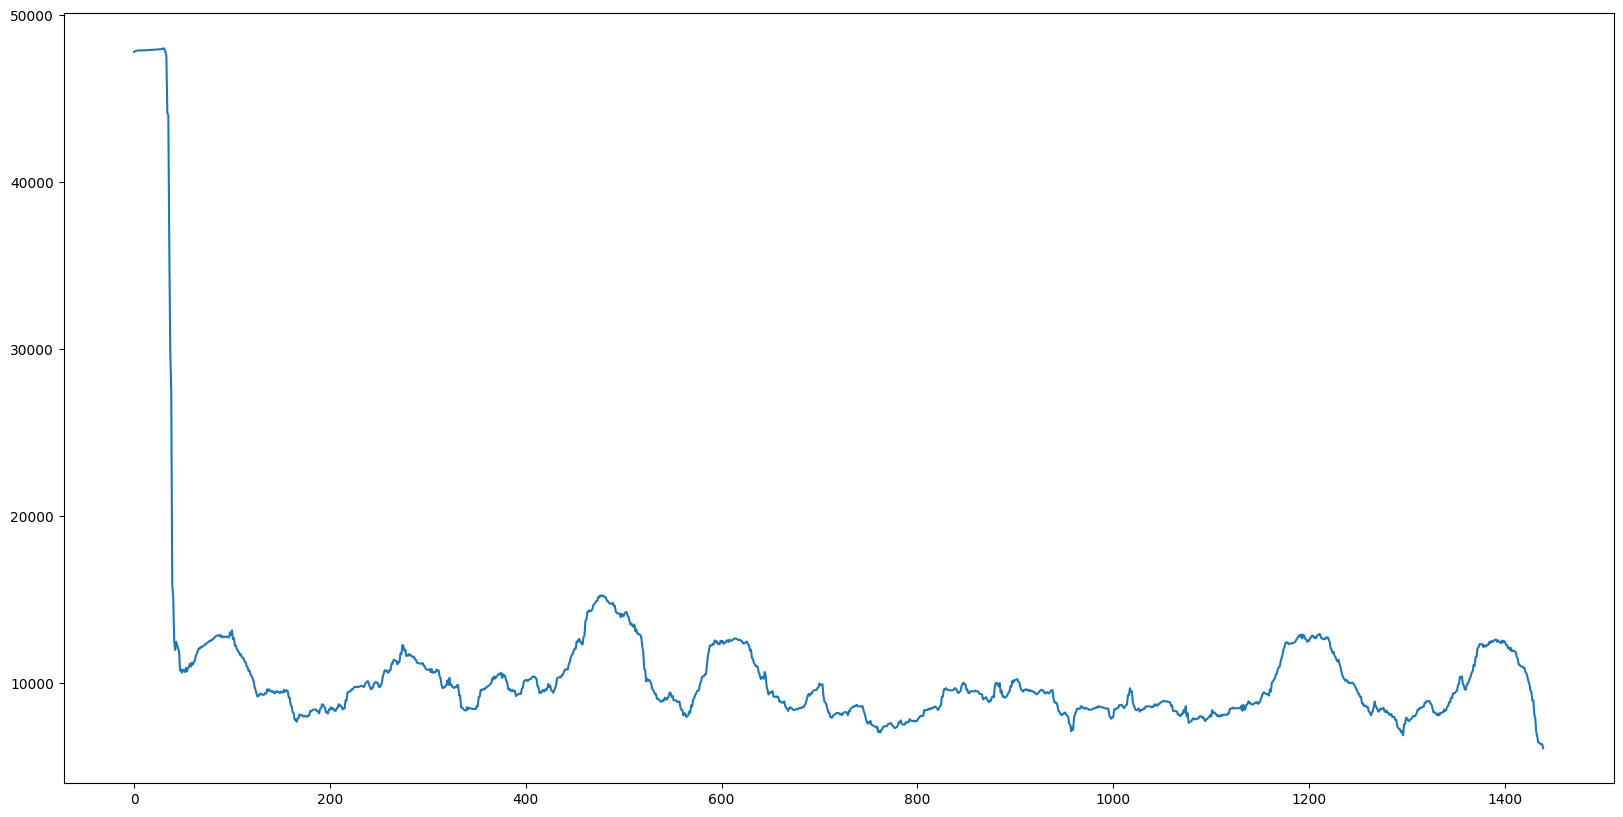

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(X[1000])

# Traning with 3000 samples

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X.shape

(3000, 1440)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape  #((1200, 2880), (300, 2880), (1200,), (300,))

((2400, 1440), (600, 1440), (2400,), (600,))

##Random Forest

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rfc.predict(X_test)

In [ ]:
print('Model accuracy score with 10 decision-trees: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees: 0.9967


<Axes: >

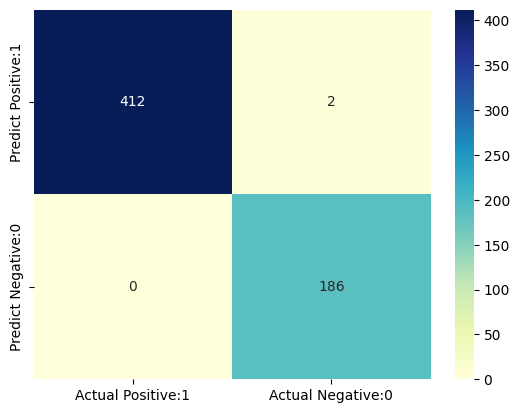

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
with open('/content/drive/MyDrive/MERMAIDAI/models/rfc_3000.pkl', 'wb') as file:
    pickle.dump(rfc, file)

## Navie Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_pred = gnb.predict(X_test)

In [ ]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.8633


<Axes: >

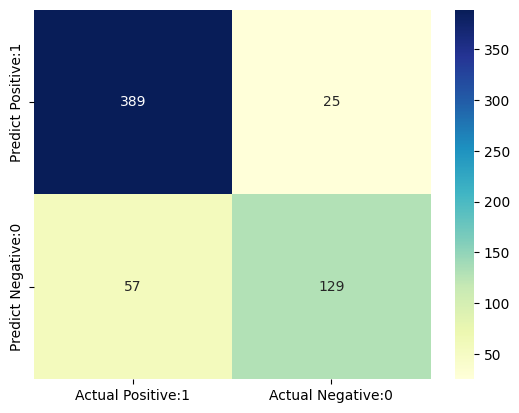

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

## SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [ ]:
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.9883


In [ ]:
# instantiate classifier with rbf kernel and C=100
svc = SVC(C=500.0)

svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [ ]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.9967


<Axes: >

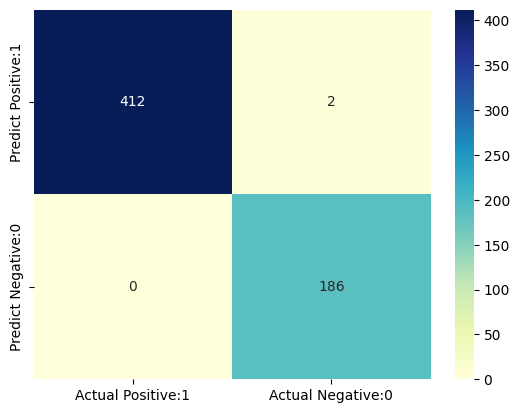

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [ ]:
with open('/content/drive/MyDrive/MERMAIDAI/models/svc_3000.pkl', 'wb') as file:
    pickle.dump(svc, file)

## Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [ ]:
y_pred_test = logreg.predict(X_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score: 0.9850


<Axes: >

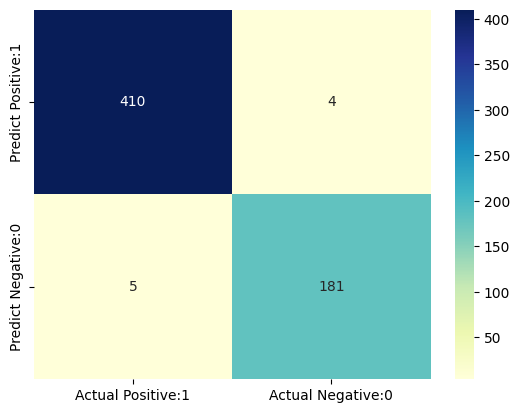

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

## kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [ ]:
y_pred = knn.predict(X_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.9950


<Axes: >

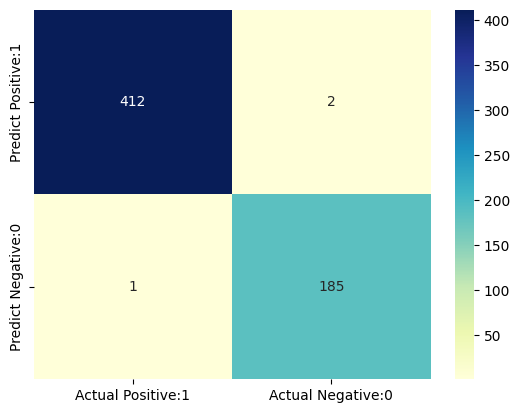

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

## NN

In [ ]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier()
clf.fit(X_train, y_train)

MLPClassifier()

In [ ]:
y_pred = clf.predict(X_test)
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.9933


<Axes: >

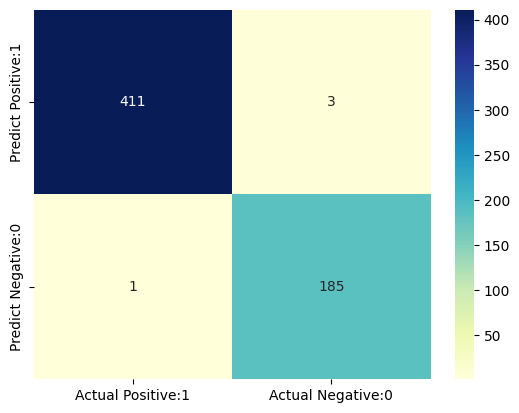

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

# 6000 signals time series

In [ ]:
demi_duree = 30*60

n = 2000

#on enlève les séismes * et S1
mask = (df['Tag']!='S1') & (df['Tag']!='*')

#20% pour le jeu de test, ne pas séparer après get_positive car le jeu de test sera biaisé
mask_t = np.random.randint(0, 10, len(mask)) < 8
files = df[ mask & mask_t]['file'].values
events_time = df[ mask & mask_t]['diff'].to_numpy(np.int32)


signal_tronque =  get_positives(files, events_time, demi_duree, n)

print(n, 'positives')

nb_0 = int(n*2)

X_0 = get_negatives(noisy_files, 2*demi_duree, nb_0)

print(nb_0, 'negatives')

y_0 = np.zeros(len(X_0))
y_1 = np.ones(len(signal_tronque))

X = np.concatenate((X_0, signal_tronque))
y = np.concatenate((y_0, y_1))


del X_0, y_0, y_1, signal_tronque

2000 positives
4000 negatives


In [ ]:
np.save('/content/drive/MyDrive/MERMAIDAI/data/6000X.csv', X)
np.save('/content/drive/MyDrive/MERMAIDAI/data/6000y.csv', y)

In [ ]:
X.shape, y.shape

((6000, 144000), (6000,))

In [ ]:
X = np.load('/content/drive/MyDrive/MERMAIDAI/data/6000X.csv.npy')
y = np.load('/content/drive/MyDrive/MERMAIDAI/data/6000y.csv.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/MERMAIDAI/data/6000X.csv.npy'

#Training with 6000 samples

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape  #((1200, 2880), (300, 2880), (1200,), (300,))

((4800, 144000), (1200, 144000), (4800,), (1200,))

## RF

In [ ]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = rfc.predict(X_test)

In [ ]:
print('Model accuracy score with 10 decision-trees: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees: 0.7700


<Axes: >

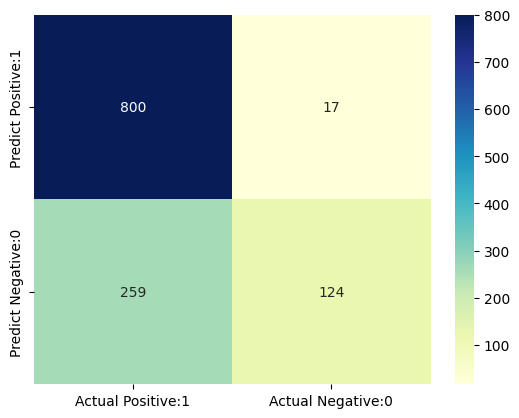

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

## SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)